# 神经网络判断最优策略

我们可以利用**深度学习中的感知器神经网络**来自动最优化出最优参数。

方法是这样：
1. 首先将一种颜色定义为1，另一种定义为-1
2. 先只考虑第二人的情况。
3. 我们考虑两个变量，分别是第一个人的选择和自身所抽中的球的颜色，当然都是以1,-1表示的。
4. 任意给定两个权重，譬如0.25,0.75（按照假定，应该是越往后次序抽到的颜色权重越重要，所以这样假设，当然也可以随机假设）。这两者对应前面两个变量的系数，也就是权重。将这两个权重分别与前两个变量乘起来，得到的和，就是对于颜色的预测。预测值大于0代表大于1的颜色，小于0代表小于-1的颜色。还有一个bias可以理解为截距。

$$
w_1x_1 + w_2x_2+b = prediction
$$

5. 定义一个损失函数，代表预测颜色和实际颜色不一致的错误率。
6. 不断调整权重，使得预测结果尽可能地好。


如果拿第三个人来举例，如果第一个选择了红色(1)，第二个人选择了蓝色(-1)，你自己抽到了蓝色(-1)。初始化的权重是0.25,0.25,0.5。
所以你对于颜色的结果预测是

$$
    \hat{P} = 1 \times 0.25 + -1 \times 0.25 + -1 \times 0.5 = -0.5 < 0 
$$

小于0,即认为是蓝色。

损失函数通常使用交叉熵损失函数，基于极大似然法的思想。它不仅衡量了猜对的个数，而且要求，颜色为1的预测结果越接近1的，比预测结果在0.9左右的更好。这要求一个sigmoid函数将预测值映射到(0,1)的概率上。

$$
L(\hat{y},y) = -ylog(\hat{y}) - (1-y)log(1-\hat{y})
$$

在感知器模型当中，损失函数只是简单的

$$
   L(w,b) = - \sum_{x_i \in M} y_i(w \times x_i + b)
$$

调整权重的算法这里使用简单的单层感知器。使用随机梯度下降法，找到一个预测错的点，然后

$$
w=w+y_i\times x_i \times \eta
$$
$$
b = b + y_i \times \eta
$$

$\eta$是学习率，小于1。

## 导入库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 图形示例
横坐标代表自身抽到的球的颜色，纵坐标代表上一个人声称的颜色。点的颜色是真实杯子的颜色。我们想要找到一根线，使得在这根线上面的都是红色的概率尽可能大，而下面的都是蓝色的概率尽可能大。

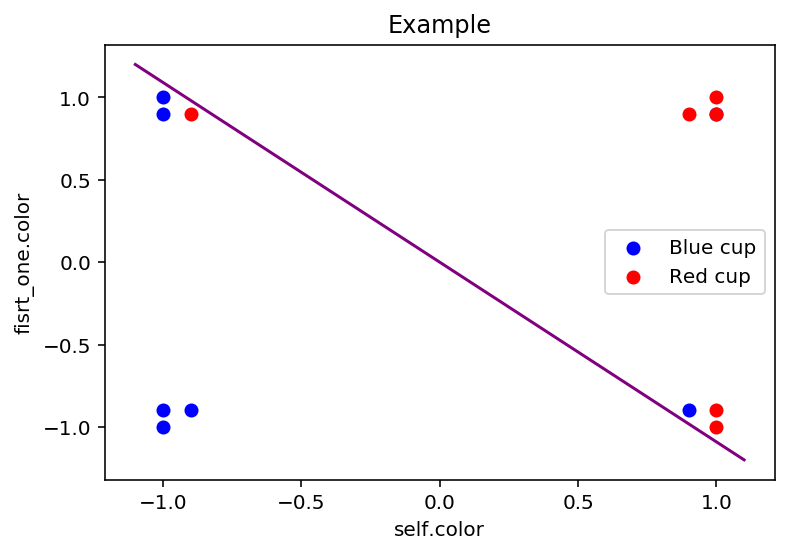

In [2]:
X = np.array([[-1,-1],[-1,0.9],[1,0.9],[-1,-0.9],[-1,1],[0.9,-0.9],[-0.9,-0.9],[-0.9,0.9],[1,-1],[0.9,0.9],[1,1],[1,0.9],[1,-0.9]])
x1,y1,x2,y2 = -1.1,1.2,1.1,-1.2
plt.scatter(X[:7, 0], X[:7, 1], color='blue',label = 'Blue cup')
plt.scatter(X[7:, 0], X[7:, 1], color='red',label = 'Red cup')
plt.plot([x1,x2], [y1,y2],'purple')
plt.xlabel('self.color')
plt.legend(loc = 'best')
plt.ylabel('fisrt_one.color')
plt.title('Example')
plt.show()

## 仿照上一篇定义类
但是红球定义为1,蓝球定义为-1，同时删去Method。

In [3]:
class Ball:
    def __init__(self, color):
        self.color = color

class Cup:
    def __init__(self, color):
        self.color = color
        if color == 1:
            self.balls = np.array([Ball(1), Ball(1), Ball(-1)])
        else:
            self.balls = np.array([Ball(1), Ball(-1), Ball(-1)])

    def pick(self):
        return self.balls[np.random.randint(0, 3)].color
    
class Cups:
    def __init__(self):
        self.Cups = np.array([Cup(1), Cup(-1)])

    def random_pick(self):
        return self.Cups[np.random.randint(0, 2)]

## 人
我们需要对人做一些改写。每次的策略实际上为

$$
    choice = sign(wx + b)
$$

$x$即info和自身抽到的球的颜色。$w$和$b$是要传递的权重和截矩。

构造函数很好理解。和上一篇一样。

`strategy(self, info, weight, bias)`是这样的，如果次序是1则所抽即所选。

是其他次序的话，需要用到权重和截矩。注意，这里的权重是一个二维数组，第一维记录的是给哪个次序的人的权重，第二位是真正的权重。比如对第二个人来说，他所利用到的权重就是weight\[1\]，而weight\[1\]里的内容假如为\[0.1,0.9\]，代表给第一个人的选择0.1的权重，给第二个人的选择为0.9的权重。

最后根据所选是不是真正的颜色来赋值一个布尔变量给right。

In [4]:
class Person:
    def __init__(self, order, Cup):
        self.order = order
        self.choice = None
        self.right = False
        self.cupcolor = Cup.color
        self.picked = Cup.pick()

    def strategy(self, info, weight, bias):
        if self.order == 1:
            self.choice = self.picked
        else:
            x = np.array(info.copy())
            x = np.append(x,self.picked)
            self.choice = np.matmul(weight[self.order - 1],x.T) + bias[self.order - 1]
            self.choice = int(np.sign(self.choice[0]))
        if self.choice == self.cupcolor:
            self.right = True

## 生成数据
每次生成数据需要指定杯子集合，指定生成多少行数据（一行为一次测试结果），指定最大的order。因为当我们要考察第二人的选择时，我们需要第一人的选择，第二人的预测值和实际的杯子颜色。此时的order_max = 1。weight是所有人的预测权重集合的集合。bias 是误差项的集合。最后的result()返回一个dataframe。

In [5]:
class GenerateData:
        def __init__(self, Cups, order_max, num, weight, bias):
            # 生成一行的数据
            for i in range(0, num):
                self.cup = Cups.random_pick()
                people = []
                info = []
                # 生成每一个人的数据
                for j in range(1,order_max + 1):                  
                    people.append(Person(j, self.cup))
                    people[j-1].strategy(info, weight, bias)
                    info.append(people[j-1].choice)
                info.append(Person(j,self.cup).picked)    
                info.append(self.cup.color)
                if i == 0:
                    self.data = pd.DataFrame([info])
                else:
                    self.data = self.data.append(pd.DataFrame([info]))
            # 定义列名
            column = []
            for i in range(1, order_max + 1):
                column.append("person_" + str(i)+"_choice")
            column.append("person_" + str(order_max + 1) + "_picked")
            column.append("truth")
            self.data.columns = column

        def result(self):
            return self.data

## 测试生成数据
假设order_max为1的时候，生成测试数据。此时weight和bias不会被纳入到计算。

假设order_max为2的时候，生成测试数据。此时weight和bias的第一项会纳入到第二个人的决策当中。这里随便给个[0.4,0.6]。

In [6]:
weight = np.array([[0],[0.4,0.6],[0,0,0],[0,0,0,0],[0,0,0,0,0],[0,0,0,0,0,0]])
bias = np.array([[0],[0],[0],[0],[0],[0]])
cups = Cups()
data = GenerateData(cups, 1, 10, weight, bias).result()
data.head(10)

,person_1_choice,person_2_picked,truth
0,1,1,-1
0,1,1,1
0,1,-1,1
0,1,1,1
0,-1,1,1
0,-1,1,-1
0,-1,1,1
0,1,-1,-1
0,-1,-1,-1
0,-1,-1,-1


In [7]:
data = GenerateData(cups, 2, 10, weight, bias).result()
data.head(10)

,person_1_choice,person_2_choice,person_3_picked,truth
0,1,1,-1,-1
0,1,1,1,1
0,-1,-1,1,-1
0,-1,1,-1,1
0,-1,-1,-1,-1
0,1,1,-1,1
0,-1,1,-1,1
0,1,-1,1,1
0,1,1,-1,1
0,1,1,1,-1


## 构建模型
数据已经生成完成，接下来要开始构建一个用来训练的模型。给定data，会随机一个weight和bias。

我们设定为当两次训练的误差变动小于0.001时停止训练。

In [8]:
class Model:
    def __init__(self, data):
        self.data = data
        self.column = data.shape[1] - 1
        self.weight = np.random.rand(self.column)
        self.bias = np.random.rand()
        self.loss = 9999999

    def train(self, learn_rate, onPrint):
        # truth 是正确的杯子颜色集合
        truth = np.array(self.data.iloc[:, -1])
        # x 是变量的集合
        x = self.data.iloc[:, :-1]
        # epoch 是训练周期
        epoch = 0
        while (True):  # 循环内为一次训练过程
            
            # 根据权重计算预测值
            prediction = np.matmul(self.weight, x.T) + self.bias

            # 计算损失
            loss = np.exp(- np.matmul(truth, prediction.T) / len(self.data))
            # 打印损失
            if onPrint:
                self.print_loss(epoch)
            if abs(self.loss - loss) < 0.001:
                if not onPrint:
                    self.print_loss(epoch)
                break
            self.loss = loss
            
            # 找到分类错的那些点
            prediction_sign = np.sign(prediction)
            self.data['prediction_sign'] = prediction_sign
            mis = self.data[self.data['prediction_sign'] != self.data['truth']].copy()
            
            # 对权重和偏差进行更新
            for j in range(int(len(mis)/2)):
                mis.iloc[j, :-2] = mis.iloc[j, :-2] * mis.iloc[j, -1]
                self.weight = self.weight + mis.iloc[j, :-2] * learn_rate
                self.bias = self.bias + mis.iloc[j, -2] * learn_rate
            epoch += 1
            
    # 打印损失和权重，用于每次训练后的返回数据
    def print_loss(self,i):
        weight_print = "["
        for k in self.weight:
            weight_print = weight_print + str(k) + " "
        weight_print += ']'
        print("loss = " + str(self.loss) + "; epoch = " + str(i + 1) + "; weight = " + weight_print + "; bias = " + str(self.bias))
    
    # 返回结果的权重和偏差
    def result(self):
        return self.weight, self.bias

## 测试你的模型
先以一个两维的作为测试。

In [9]:
weight = np.array([[0], [0, 0], [0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])
bias = np.array([[0], [0], [0], [0], [0], [0]])
data = GenerateData(cups, 1, 5000, weight, bias).result()
model = Model(data)
model.train(0.001, True)

loss = 9999999; epoch = 1; weight = [0.23987547045547986 0.21621967077143467 ]; bias = 0.2998413553519006
loss = 0.8712734204705787; epoch = 2; weight = [0.5688754704554801 0.4552196707714349 ]; bias = -0.3051586446480999
loss = 0.707664593303057; epoch = 3; weight = [0.8338754704554804 0.7622196707714352 ]; bias = 0.20384135535190054
loss = 0.5980441873867081; epoch = 4; weight = [1.1628754704554627 1.0012196707714351 ]; bias = -0.40115864464809997
loss = 0.48574269190456254; epoch = 5; weight = [1.4278754704554335 1.3082196707714013 ]; bias = 0.10784135535190047
loss = 0.41049897961292714; epoch = 6; weight = [2.27687547045534 1.029219670771432 ]; bias = 0.02284135535190039
loss = 0.3421823708965515; epoch = 7; weight = [3.1258754704552465 0.750219670771435 ]; bias = -0.06215864464809967
loss = 0.2852352399579475; epoch = 8; weight = [3.974875470455153 0.4712196707714348 ]; bias = -0.14715864464809975
loss = 0.23776544040155903; epoch = 9; weight = [4.823875470455425 0.19221967077143

我们尝试作图来看看最后的划分线落在哪里。如果你对上面的反复做几次，你会发现答案都不一样，但是绘制出来的直线是一样的。

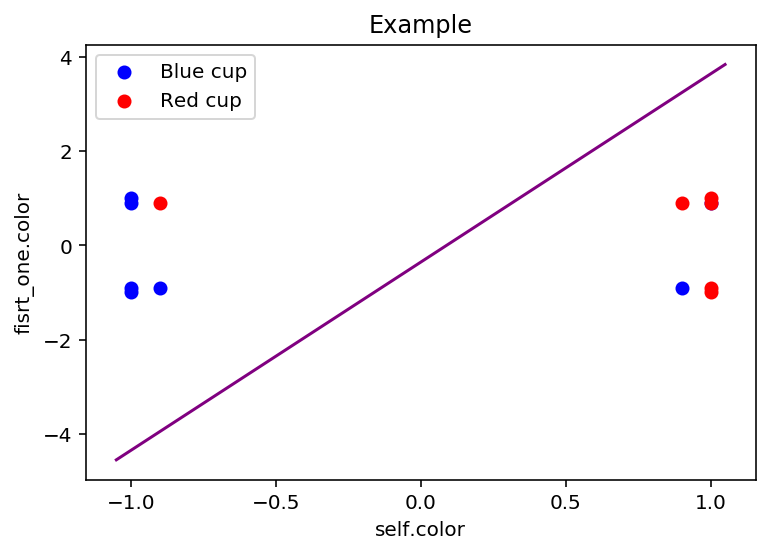

In [10]:
weight_1,bias_1 = model.result()
X = np.array([[-1,-1],[-1,0.9],[1,0.9],[-1,-0.9],[-1,1],[0.9,-0.9],[-0.9,-0.9],[-0.9,0.9],[1,-1],[0.9,0.9],[1,1],[1,0.9],[1,-0.9]])
plt.scatter(X[:7, 0], X[:7, 1], color='blue',label = 'Blue cup')
plt.scatter(X[7:, 0], X[7:, 1], color='red',label = 'Red cup')
y1 = - ( 1.05 * weight_1[0] + bias_1) / weight_1[1]
y2 = - ( -1.05 * weight_1[0] + bias_1) / weight_1[1]
plt.plot([1.05,-1.05], [y1,y2],'purple')
plt.xlabel('self.color')
plt.legend(loc = 'best')
plt.ylabel('fisrt_one.color')
plt.title('Example')
plt.show()

可以看得到，我们的直线还是有明显的分割数据的痕迹。Nice!

## 坐稳了吗？
维数要升上去了！

In [11]:
class MultiTest:
    def __init__(self, num):
        self.num = num
        cups = Cups()
        self.weight = np.array([[0], [0, 0], [0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])
        self.bias = np.array([[0], [0], [0], [0], [0], [0]])
        for i in range(1, 7):
            data = GenerateData(cups, i, num, self.weight, self.bias).result()
            print("order = " + str(i))
            model = Model(data)
            model.train(0.001, False)
            if i < 6:
                self.weight[i],self.bias[i] = model.result()
        self.data = GenerateData(cups, 6, num, self.weight, self.bias).result()
        
    def result(self):
        return self.data.drop(['person_7_picked'],axis=1)

# Attention! 开始训练!

In [15]:
num = 5000
data = MultiTest(num)

order = 1
loss = 0.005632615600654567; epoch = 28; weight = [-6.9400970623982206 23.644636498581562 ]; bias = 1.0439756387293708
order = 2
loss = 0.012129428414900171; epoch = 56; weight = [-14.95722278061538 46.088491656124184 -16.13441487947676 ]; bias = -1.2900657211884876
order = 3
loss = 0.0024075511379628317; epoch = 18; weight = [-2.8635679182045157 14.06077748591194 13.782396723647578 -4.9053285240665785 ]; bias = -0.33361307832754755
order = 4
loss = 0.0013965637022787863; epoch = 12; weight = [-2.1373722732520526 8.447166586885972 9.105230463980694 8.751180879482295 -2.090788136470222 ]; bias = -0.7294047529291638
order = 5
loss = 0.000868608869866401; epoch = 9; weight = [-1.8382259255099622 7.022554425066799 7.611470890947788 6.811853615522083 7.325222400362925 -2.170812655689555 ]; bias = 0.15422166071888854
order = 6
loss = 0.0008766155301412153; epoch = 7; weight = [-0.7047889477000489 6.1073293159417625 5.413637735955178 5.508093914343887 5.208391688772499 5.93210511432

## 查看训练结果

In [16]:
result = data.result()
result.head()

,person_1_choice,person_2_choice,person_3_choice,person_4_choice,person_5_choice,person_6_choice,truth
0,1,1,1,1,1,1,-1
0,1,1,1,1,1,1,-1
0,1,1,1,1,1,1,1
0,1,1,1,1,1,1,1
0,1,1,1,1,1,1,-1


让我们使用老方法来完整地统计并绘图。

In [17]:
ratio = []
for i in range(1,7):
    string = 'person_' + str(i) + "_choice"
    temp = (len(result[result[string] == result['truth']]))/num
    ratio.append(temp)
ratio = pd.DataFrame(ratio,index = [1,2,3,4,5,6])
ratio.columns = ['correct ratio']
ratio

,correct ratio
1,0.6704
2,0.6616
3,0.6616
4,0.6616
5,0.6616
6,0.6616


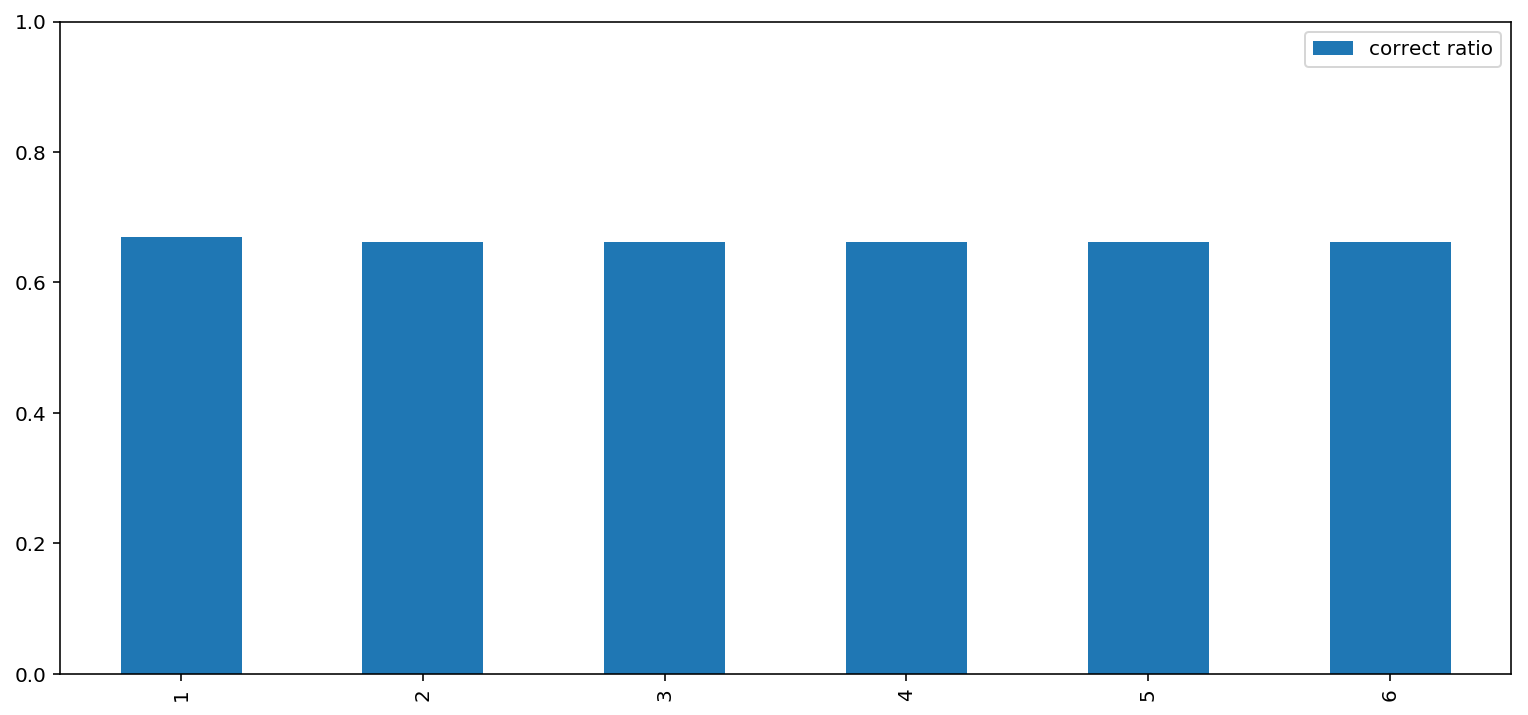

In [18]:
ratio.plot(kind='bar', ylim=(0, 1), figsize=(13, 6))

# 这就是神经网络
它并不比我们推导出来的最优解更好。

这是因为，我们的数据是线性不可分的，天然不是一个适合用神经网络的数据集。